# Basic Iterative Method Attack

Use MNIST data to train a Convolutional Neural Network classification model, and then attack that model with a Basic Iterative Method attack

## Load MNIST data; Plot MNIST Examples; Consrtuct the Convolutional Neural Network; Implement: Cross Entropy Loss, Gradient Descent with Adam optimizer, Learning Rate, and Epochs; Train and Test the model

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


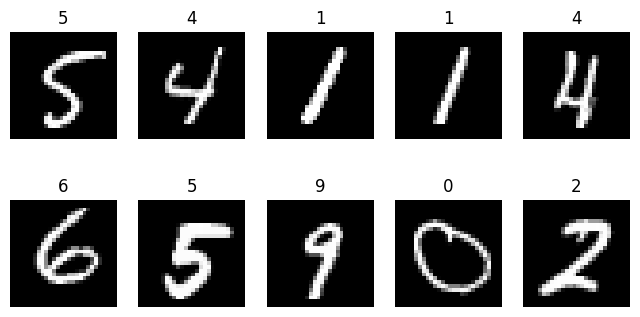

epoch (1): Train accuracy: 0.9503, loss: 0.002
epoch (2): Train accuracy: 0.9774, loss: 0.001
epoch (3): Train accuracy: 0.9779, loss: 0.001
epoch (4): Train accuracy: 0.9792, loss: 0.001
epoch (5): Train accuracy: 0.9792, loss: 0.001
epoch (6): Train accuracy: 0.9796, loss: 0.001
epoch (7): Train accuracy: 0.9794, loss: 0.001
epoch (8): Train accuracy: 0.9789, loss: 0.001
epoch (9): Train accuracy: 0.9819, loss: 0.001
epoch (10): Train accuracy: 0.9802, loss: 0.001
 
Test accuracy: 0.9789
 
Confusion Matrix

[[ 932    3    4    0    0    0   39    1    0    1]
 [   0 1133    0    0    0    2    0    0    0    0]
 [   0    2 1024    0    3    0    0    2    1    0]
 [   0    0    5  988    0    7    0    4    4    2]
 [   0    4    0    0  967    0    1    0    0   10]
 [   0    1    0    2    0  870   15    1    1    2]
 [   0    6    0    0    1    1  950    0    0    0]
 [   0   11    8    0    5    0    0  990    1   13]
 [   2    3    3    0    3    0   11    0  945    7]
 [   0  

In [1]:
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

import matplotlib as mpl
import matplotlib.pyplot as plt

#Convert the dataset into Tensor
transform=transforms.Compose([
         transforms.ToTensor(),
        ])

#Download the MINST data directly from PyTorch
#For train dataset, use "train=True"
#For test dataset, use "train=False"
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

#Load the datasets into DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

class_names = ['0', '1', '2', '3', '4',
               '5', '6', '7', '8', '9']

#One batch has 64 images
dataiter = iter(train_dataloader)
samples = next(dataiter)

def plot_digits(instances, labels, images_per_row=5):
    for i in range(len(instances)):
        idx = i // images_per_row
        idy = i % images_per_row 
        ax[idx, idy].imshow(instances[i].squeeze(), cmap="gray")
        ax[idx, idy].set_title(class_names[labels[i]])
        ax[idx, idy].axis("off")

fig, ax = plt.subplots(2, 5, figsize=(8, 4))
example_images = samples[0][:10]
example_labels = samples[1][:10]
plot_digits(example_images, example_labels, images_per_row=5)
plt.show()

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)  #The input image has one channel, and 10 channels are generated after the first convolution layer 
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) #20 channels are generated after the second convolution layer
        self.fc1 = nn.Linear(320, 50)                 #The first fully-connected layer
        self.fc2 = nn.Linear(50, 10)                  #The second fully-connected layer

    def forward(self, x):
        x = F.relu(self.conv1(x))                     #The first convolution layer using ReLU activation function
        x = F.max_pool2d(x, 2)                        #The first pooling layer using max and pooling size is 2x2
        x = F.relu(self.conv2(x))                     #The second convolution layer using ReLU activation function
        x = F.max_pool2d(x, 2)                        #The second pooling layer using max and pooling size is 2x2
        x = torch.flatten(x, 1)                       #Flattern all channels into a feature vector
        x = F.relu(self.fc1(x))                       #The first fully-connected layer
        x = self.fc2(x)                               #The second fully-connected layer
        return x
    
    np.random.seed(42)
torch.manual_seed(42)
epochs = 10
learning_rate = 0.01
weight_decay = 5e-4
lossfunction = nn.CrossEntropyLoss()

model = CNN()

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

def train(epoch, model, train_dataloader, optimizer, lossfunction):
    model.train()
    
    train_loss = 0.0
    train_total, train_correct = 0.0, 0.0 
    
    for X_batch, y_batch in train_dataloader:
        optimizer.zero_grad()

        #Get the predicted output
        predictions = model(X_batch)

        #Calculate the loss
        loss = lossfunction(predictions, y_batch)
        
        #Update the weights usning gradient descent with Adam optimizer
        loss.backward()
        optimizer.step()
        
        #Convert probabilities to multi-class predictions (reutrn the class with the maximal proability)
        _, train_predicted = torch.max(predictions.data, 1)
        
        #Calculate the training statistics
        train_loss += loss.item()
        train_total += y_batch.size(0)
        train_correct += (train_predicted == y_batch).sum().item()

    print("epoch (%d): Train accuracy: %.4f, loss: %.3f" % (epoch, train_correct/train_total, train_loss/train_total))

def test(model, test_dataloader):
    model.eval()
    
    test_correct, test_total = 0.0, 0.0
    y_test, y_pred = [], []
    
    with torch.no_grad():
        for X_batch, y_batch in test_dataloader:
            predictions = model(X_batch)
            
            _, test_predicted = torch.max(predictions.data, 1)
            test_total += y_batch.size(0)
            test_correct += (test_predicted == y_batch).sum().item()
            
            y_test += y_batch.tolist()
            y_pred += test_predicted.tolist()

    print(' ')
    print('Test accuracy: %.4f' % (test_correct / test_total))
    
    return y_test, y_pred

#Define the function that returns a predicted label for a single input sample
def predict_label(model, single_input):
    model.eval()  
    with torch.no_grad():
        prediction = model(single_input)
        _, predicted_label = torch.max(prediction.data, 1)
    
    return predicted_label

#Define the function that returns predicted probabilities for a single input sample
def predict_probabilities(model, single_input):
    model.eval()  
    with torch.no_grad():
        prediction = model(single_input)
        predicted_probabilities = torch.softmax(prediction, dim=1).squeeze(0)
    
    return predicted_probabilities

for epoch in range(1, epochs + 1):
    train(epoch, model, train_dataloader, optimizer, lossfunction)
    

#Test the model
model.eval()
y_test, y_pred = test(model, test_dataloader)

confusion = confusion_matrix(y_test, y_pred)
print(' ')
print('Confusion Matrix\n')
print(confusion)

print(' ')

acc = accuracy_score(y_test, y_pred)
macrof1 = f1_score(y_test, y_pred, average='macro')
microf1 = f1_score(y_test, y_pred, average='micro')

print('Accuracy: {:.2f}'.format(acc))
print('Macro F1-score: {:.2f}'.format(macrof1))
print('Micro F1-score: {:.2f}'.format(microf1))

## Implementing Basic Iterative Method Attack

#### Attack Function:
Step 1: adv_x⁰ = x

Step 2: adv_x⁽ᵗ⁺¹⁾ = Clip_{x, ε} [ adv_x⁽ᵗ⁾ + α * sign(∇_{adv_x⁽ᵗ⁾} Loss(adv_x⁽ᵗ⁾, y, w)) ]


The difference between FGSM and BIM is that the Basic Iterative Method applys FGSM in small steps multiple times, instead of on one step.


adv_x⁰ = x is the initial adversarial image, which is a clean image with no perturbations.

adv_x⁽ᵗ⁺¹⁾ is the updated adversarial image at t+1 iterations.

Clip_{x, ε} is a clip to limit large perturbations from occuring in a single step.

ε is the maximum size a perturbation can be.

α is the size of the perturbation performed.

adv_x⁽ᵗ⁾ + α * sign(∇_{adv_x⁽ᵗ⁾} Loss(adv_x⁽ᵗ⁾, y, w)) is the standard FGSM function, but instead of using the clean x image, it uses the updated adversarial image adv_x⁽ᵗ⁺¹⁾ for each iteration.

In [14]:
def bim_attack(epsilon, alpha, image_input, true_label, iterations):
    # Clone the input and keep the original image
    original_image = image_input.clone().detach()
    
    #Set requires_grad attribute of image_input tensor as true, which will be used to get the gradient
    adv_image = image_input.clone().detach().requires_grad_(True)
    
    for _ in range(iterations):
        prediction = model(adv_image)
        
        #Calculate the loss
        loss = lossfunction(prediction, true_label)
        
        # Zero all existing gradients
        model.zero_grad()
        
        #Calculate gradients of loss in backward pass
        loss.backward()
        
        #Obtain the gradient regarding input image
        image_input_grad = adv_image.grad.data
        
        #perform BIM attack
        #Take small step in direction of gradient
        sign_grad = image_input_grad.sign()
        
        #Generate the perturbed image by adding the perturbation with alpha and direction of gradient to the input image
        adv_image = adv_image + alpha * sign_grad
        
        # Clamp perturbation to stay within epsilon of original image
        # perturbation = torch.clamp(adv_image - original_image, min=epsilon, max=epsilon)
        adv_image = torch.max(torch.min(adv_image, original_image + epsilon), original_image - epsilon)
        adv_image = torch.clamp(adv_image, 0, 1).detach()
        # adv_image = torch.clamp(original_image + perturbation, 0, 1).detach() # changed original_image to adv_image in parameter
        adv_image.requires_grad_()
        
    return adv_image

#### Implement the Basic Iterative Method attack with different epsilons to see created adversarial examples.

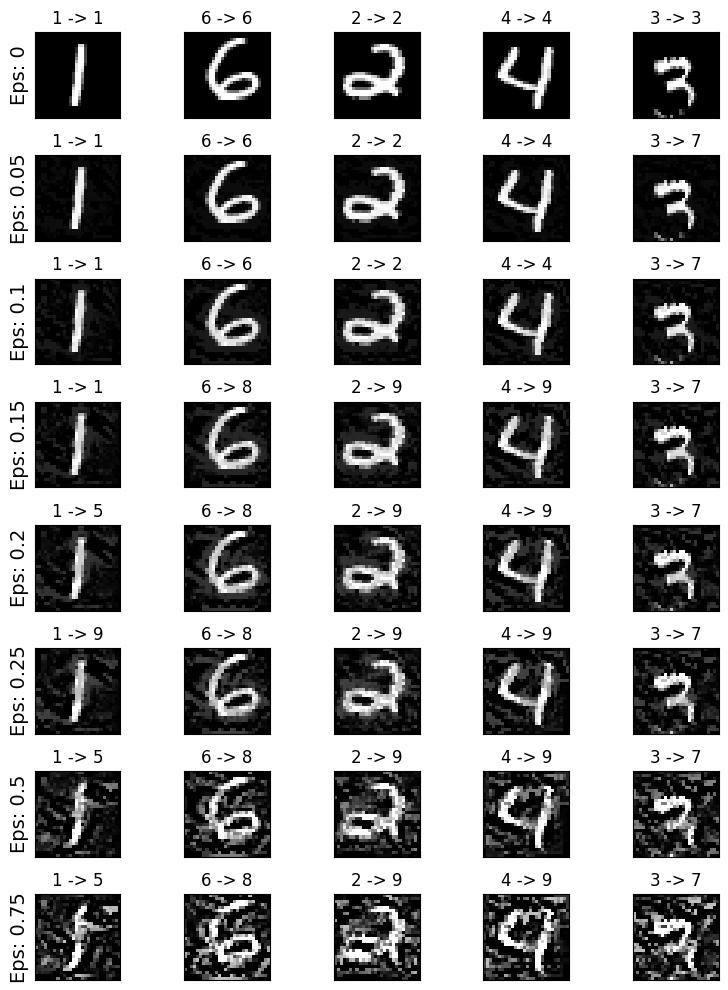

In [15]:
#epsilons
epsilons = [0, .05, .1, .15, .2, .25, 0.5, 0.75]

#Choose a random set of test images as input
#Set the random seed
np.random.seed(42)

#Number of test samples
number_of_samples = len(test_dataset)
#Get a set of random indices from [0, number_of_samples)
indices = np.random.randint(number_of_samples, size=5)

#Select the test input to perturb
test_images = torch.stack([test_dataset[i][0] for i in indices])
test_imagelabels = torch.tensor([test_dataset[i][1] for i in indices])

adversarial_examples = []
true_labels = []
adv_labels = []

for epsilon in epsilons:
    
    #Suggested hyperparameters by attack creators
    alpha = 0.01
    iterations = int(min(epsilon / alpha + 4, 1.25 * epsilon / alpha))
    
    perturbed_image = bim_attack(epsilon, alpha, test_images, test_imagelabels, iterations)
    
    # Re-classify the perturbed image
    adv_label = predict_label(model, perturbed_image)
    
    adversarial_examples.append(perturbed_image.detach().numpy())
    true_labels.append(test_imagelabels)
    adv_labels.append(adv_label)


# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(adversarial_examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(adversarial_examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
        orig, adv, ex = true_labels[i][j], adv_labels[i][j], adversarial_examples[i][j].squeeze(0) 
        plt.title(f"{orig} -> {adv}")
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

#### Exaluate the model using the perturbed dataset.

In [16]:
def attack_model(model, test_dataloader, epsilon, alpha):
    model.eval()
    y_true_all, y_pred_all = [], []
    
    for X_batch, y_batch in test_dataloader:
        X_batch_adv = X_batch.clone().detach()
        y_batch = y_batch.clone().detach()
        
        iterations = int(min(epsilon / alpha + 4, 1.25 * epsilon / alpha))
        
        X_batch_adv = bim_attack(epsilon, alpha, X_batch, y_batch, iterations)
            
        with torch.no_grad():
            final_preds = model(X_batch_adv)
            _, predicted = torch.max(final_preds.data, 1)
            y_true_all += y_batch.tolist()
            y_pred_all += predicted.tolist()
            
    accuracy = accuracy_score(y_true_all, y_pred_all)
    macrof1 = f1_score(y_true_all, y_pred_all, average='macro')
    microf1 = f1_score(y_true_all, y_pred_all, average='micro')
    confusion = confusion_matrix(y_true_all, y_pred_all)
    
    print('-------------------------------------------------------------------------------')
    print(f"Evaluation with BIM attack with epsilon = {epsilon} and alpha = {alpha}")
    print("Test Accuracy: {:.4f}\n".format(accuracy))
    print("Confusion Matrix\n")
    print(confusion)
    print('')
    print("Macro F1-score: {:.4f}".format(macrof1))
    print("Micro F1-score: {:.4f}".format(microf1))

epsilons = np.arange(0.0, 1.0, 0.05).round(2).tolist()
    
for eps in epsilons:
    attack_model(model, test_dataloader, epsilon=eps, alpha=0.01)

-------------------------------------------------------------------------------
Evaluation with BIM attack with epsilon = 0.0 and alpha = 0.01
Test Accuracy: 0.9789

Confusion Matrix

[[ 932    3    4    0    0    0   39    1    0    1]
 [   0 1133    0    0    0    2    0    0    0    0]
 [   0    2 1024    0    3    0    0    2    1    0]
 [   0    0    5  988    0    7    0    4    4    2]
 [   0    4    0    0  967    0    1    0    0   10]
 [   0    1    0    2    0  870   15    1    1    2]
 [   0    6    0    0    1    1  950    0    0    0]
 [   0   11    8    0    5    0    0  990    1   13]
 [   2    3    3    0    3    0   11    0  945    7]
 [   0    1    2    0    8    4    0    3    1  990]]

Macro F1-score: 0.9788
Micro F1-score: 0.9789
-------------------------------------------------------------------------------
Evaluation with BIM attack with epsilon = 0.05 and alpha = 0.01
Test Accuracy: 0.8476

Confusion Matrix

[[ 635    7   31    1    1    2  263    5    1   34]
